# 1. Imports

In [1]:
# importing other dependencies
import numpy as np
import pandas as pd
# importing PyTorch
import torch
# importing torch.nn Module
import torch.nn as nn
# to load the activation functions
import torch.nn.functional as F
# importing Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, TensorDataset
# import Compose to compose transforms
from torchvision.transforms import Compose
# plotting
import matplotlib.pyplot as plt

In [2]:
# checks whether MPS is available
print(torch.backends.mps.is_available())

# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

# setting the device to "mps" instead of default "cpu"
device = torch.device("mps" if torch.backends.mps.is_available else "cpu")

True
True


In [3]:
# training on GPU
device

device(type='mps')

# 2. Preparing Data

In this case we use the in-built `CIFAR10` dataset provided by PyTorch. This has `60000`, `32 * 32` color images in `10` with approximately `1000` images per class.

In [4]:
str_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# some hyper-parameters
batch_size = 5
num_epochs = 10
learning_rate = 0.001

In [6]:
# MNIST dataset
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# train
# keep download=True, the first time
'''
train_dataset = CIFAR10(
    root='./data/CIFAR10/',
    train=True,
    transform=ToTensor(),
    download=True
)
'''
train_dataset = CIFAR10(
    root='./data/CIFAR10/',
    train=True,
    transform=ToTensor(),
    download=False
)


# test
test_dataset = CIFAR10(
    root='./data/CIFAR10/',
    train=False,
    transform=ToTensor()
    # don't have to download again
)

# DataLoader

#train
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

#test
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=len(test_dataset),
    shuffle=False
)

Let's analyse the data.

In [7]:
# extracting the test dataset
X_test, y_test = next(iter(test_loader))
# move the data to GPU
X_test, y_test = X_test.to(device), y_test.to(device)
# print the shape
print(X_test.shape, y_test.shape)

torch.Size([10000, 3, 32, 32]) torch.Size([10000])


So, we have `10000` examples in our test set, which are `32*32` triple-channeled colored images. We try visualizing these images:

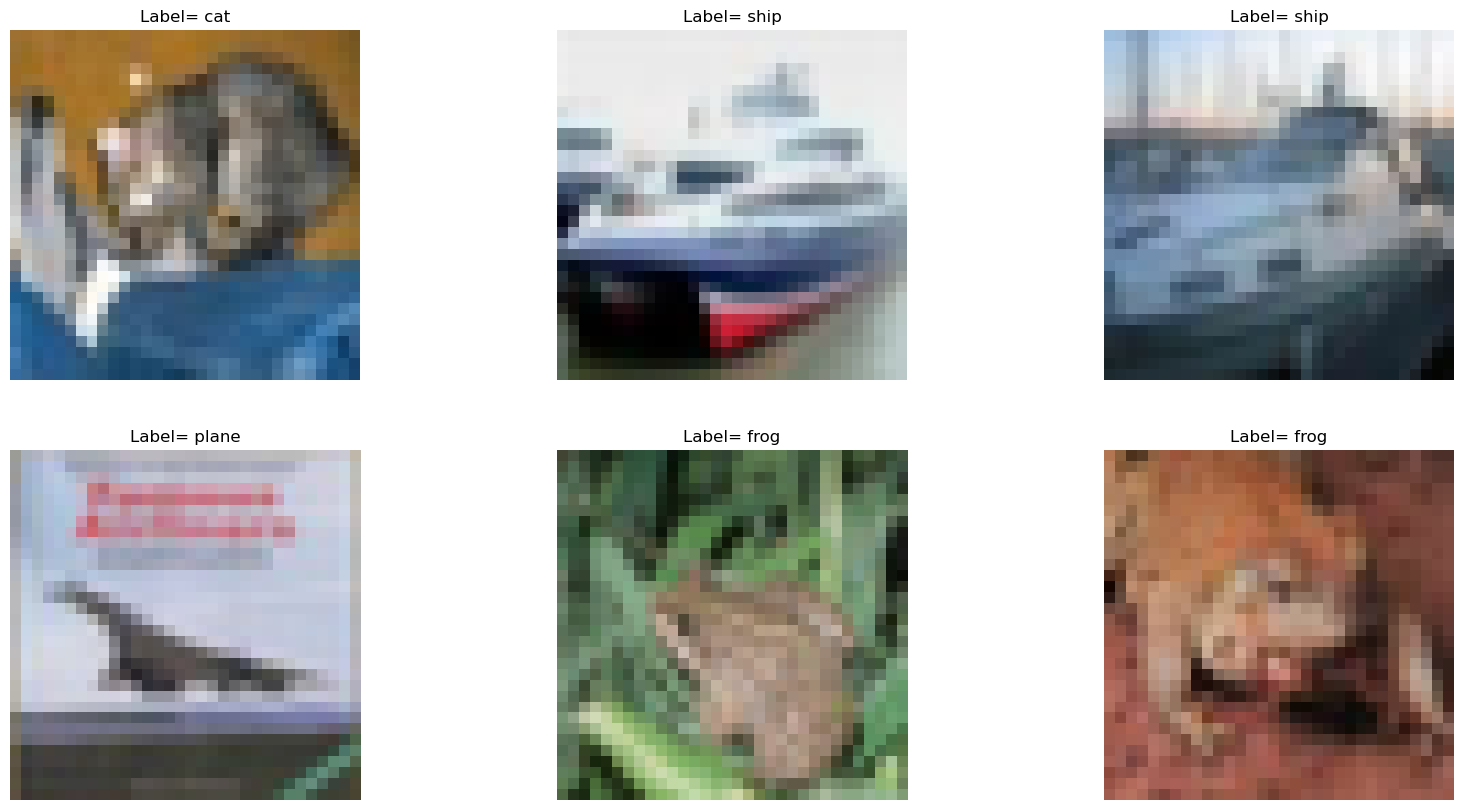

In [8]:
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we have multi-channel image
    img = np.transpose(img, (1,2,0))
    plt.imshow(img)
    plt.title("Label= " + str_labels[y_test[i].item()])
    plt.grid(False)
    plt.axis(False)
plt.show()

# 3. Model

We use the architecture inspired from the LeNet-5 architecture. We modify this by replacing the Average Pooling layers by Max Pooling layers.

![](https://i.postimg.cc/XNDxWGGG/image.png)

We can define a 2D Convolution Layer by the following syntax:
- `nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True, padding_mode='zeros', dtype=None)`

    - Suppose the input dimension is $[c_i, n, n]$, where $c_i$ is the no. of input channels.
    - This will require $c_o$ no. of filters of dimensions $[c_i, f, f]$, where $f$ is the kernel size.
    - Suppose $p$ is the padding and $s$ is stride.

- Then the output dimension is $[c_o, \frac{n + 2p - f}{s} + 1, \frac{n + 2p - f }{s} + 1]$

We can define a 2D Pooling Layer by the following syntax:
- `nn.MaxPool2d(kernel_size, stride=None, padding=0)`
- `nn.AvgPool2d(kernel_size, stride=None, padding=0)`

In [25]:
class CNN_LeNet5(nn.Module):
    def __init__(self):
        super(CNN_LeNet5, self).__init__()

        # defining the layers
        
        # Convolution and Pooling Layers

        # input = 3,32,32
        # conv-layer-1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.relu1 = nn.ReLU()

        # input = 6,28,28
        # max-pooling-1
        self.maxp1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # input = 6,14,14
        # conv-layer-2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.relu2 = nn.ReLU()

        # input = 16,10,10
        self.maxp2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        
        # input = 16,5,5
        # flatten this to 16*5*5 dimensional array
        # fcc-layer-3
        self.fcc3 = nn.Linear(in_features=16*5*5, out_features=120)
        self.relu3 = nn.ReLU()

        # input = 120
        # fcc-layer-4
        self.fcc4 = nn.Linear(in_features=120, out_features=84)
        self.relu4 = nn.ReLU()

        # input = 84
        # fcc-layer-5
        self.fcc5 = nn.Linear(in_features=84, out_features=10)
        # no softmax layer, already included in CrossEntropyLoss
    
    def forward(self, X):
        # n,3,32,32
        # layer-1
        out = self.relu1(self.conv1(X))
        out = self.maxp1(out)
        
        # n,16,14,14
        # layer-2
        out = self.relu2(self.conv2(out))
        out = self.maxp2(out)
        
        # n,16,5,5
        # flatten out the output from 16,5,5 to 1,16*5*5
        out = out.view(-1, 16*5*5)

        # n,16*5*5
        # layer-3
        out = self.relu3(self.fcc3(out))
        
        # n,120
        # layer-4
        out = self.relu4(self.fcc4(out))
        
        # n,84
        #  layer-5
        out = self.fcc5(out)
        # no softmax layer, already included in CrossEntropyLoss
        # n,10
        return out


Let's initialize the model and test the result of the test dataset.

In [26]:
# define the model
model = CNN_LeNet5().to(device=device)

In [27]:
# we also check the initial accuracy on the test data before training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Initial Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Initial Accuracy on test data: 0.1


# 4. Training

In [28]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr = learning_rate
)

# total no. of update steps
n_total_steps = len(train_loader)

# training
for epoch in range(num_epochs):
    # load training data in batched via train_loader
    for (idx, batch) in enumerate(train_loader):
        # extract features and labels
        X_train_batch, y_train_batch = batch
        # adding the batch to the GPU
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

        # training processes
        # forward pass:
        # compute prediction
        y_train_batch_pred = model(X_train_batch)
        # compute loss
        loss = criterion(y_train_batch_pred, y_train_batch)
        # this applies soft-max by itself

        # backward pass:
        # compute gradients
        loss.backward()

        # update weights:
        optimizer.step()
        # zero-gradients after updating
        optimizer.zero_grad()

        # print info after every 100 mini-batches
        if idx%2000 == 0:
            print('-------------------------------')
            print(f'Epoch: {epoch+1}/{num_epochs}')
            print(f'Steps: {idx+1}/{n_total_steps}')
            print(f'Loss: {loss.item()}')

-------------------------------
Epoch: 1/10
Steps: 1/10000
Loss: 2.323699474334717
-------------------------------
Epoch: 1/10
Steps: 2001/10000
Loss: 1.4574089050292969
-------------------------------
Epoch: 1/10
Steps: 4001/10000
Loss: 2.7622501850128174
-------------------------------
Epoch: 1/10
Steps: 6001/10000
Loss: 1.6714495420455933
-------------------------------
Epoch: 1/10
Steps: 8001/10000
Loss: 1.0903468132019043
-------------------------------
Epoch: 2/10
Steps: 1/10000
Loss: 0.5491313338279724
-------------------------------
Epoch: 2/10
Steps: 2001/10000
Loss: 1.0634784698486328
-------------------------------
Epoch: 2/10
Steps: 4001/10000
Loss: 3.0178604125976562
-------------------------------
Epoch: 2/10
Steps: 6001/10000
Loss: 1.3720545768737793
-------------------------------
Epoch: 2/10
Steps: 8001/10000
Loss: 1.8298355340957642
-------------------------------
Epoch: 3/10
Steps: 1/10000
Loss: 1.1297613382339478
-------------------------------
Epoch: 3/10
Steps: 20

# 5. Evaluation

In [29]:
# we also check the final accuracy on the test data after training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Final Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Final Accuracy on test data: 0.5988


Note: The accuracy has improved from `10%` to `59.88%`.

We, can also visualize some of the predictions.

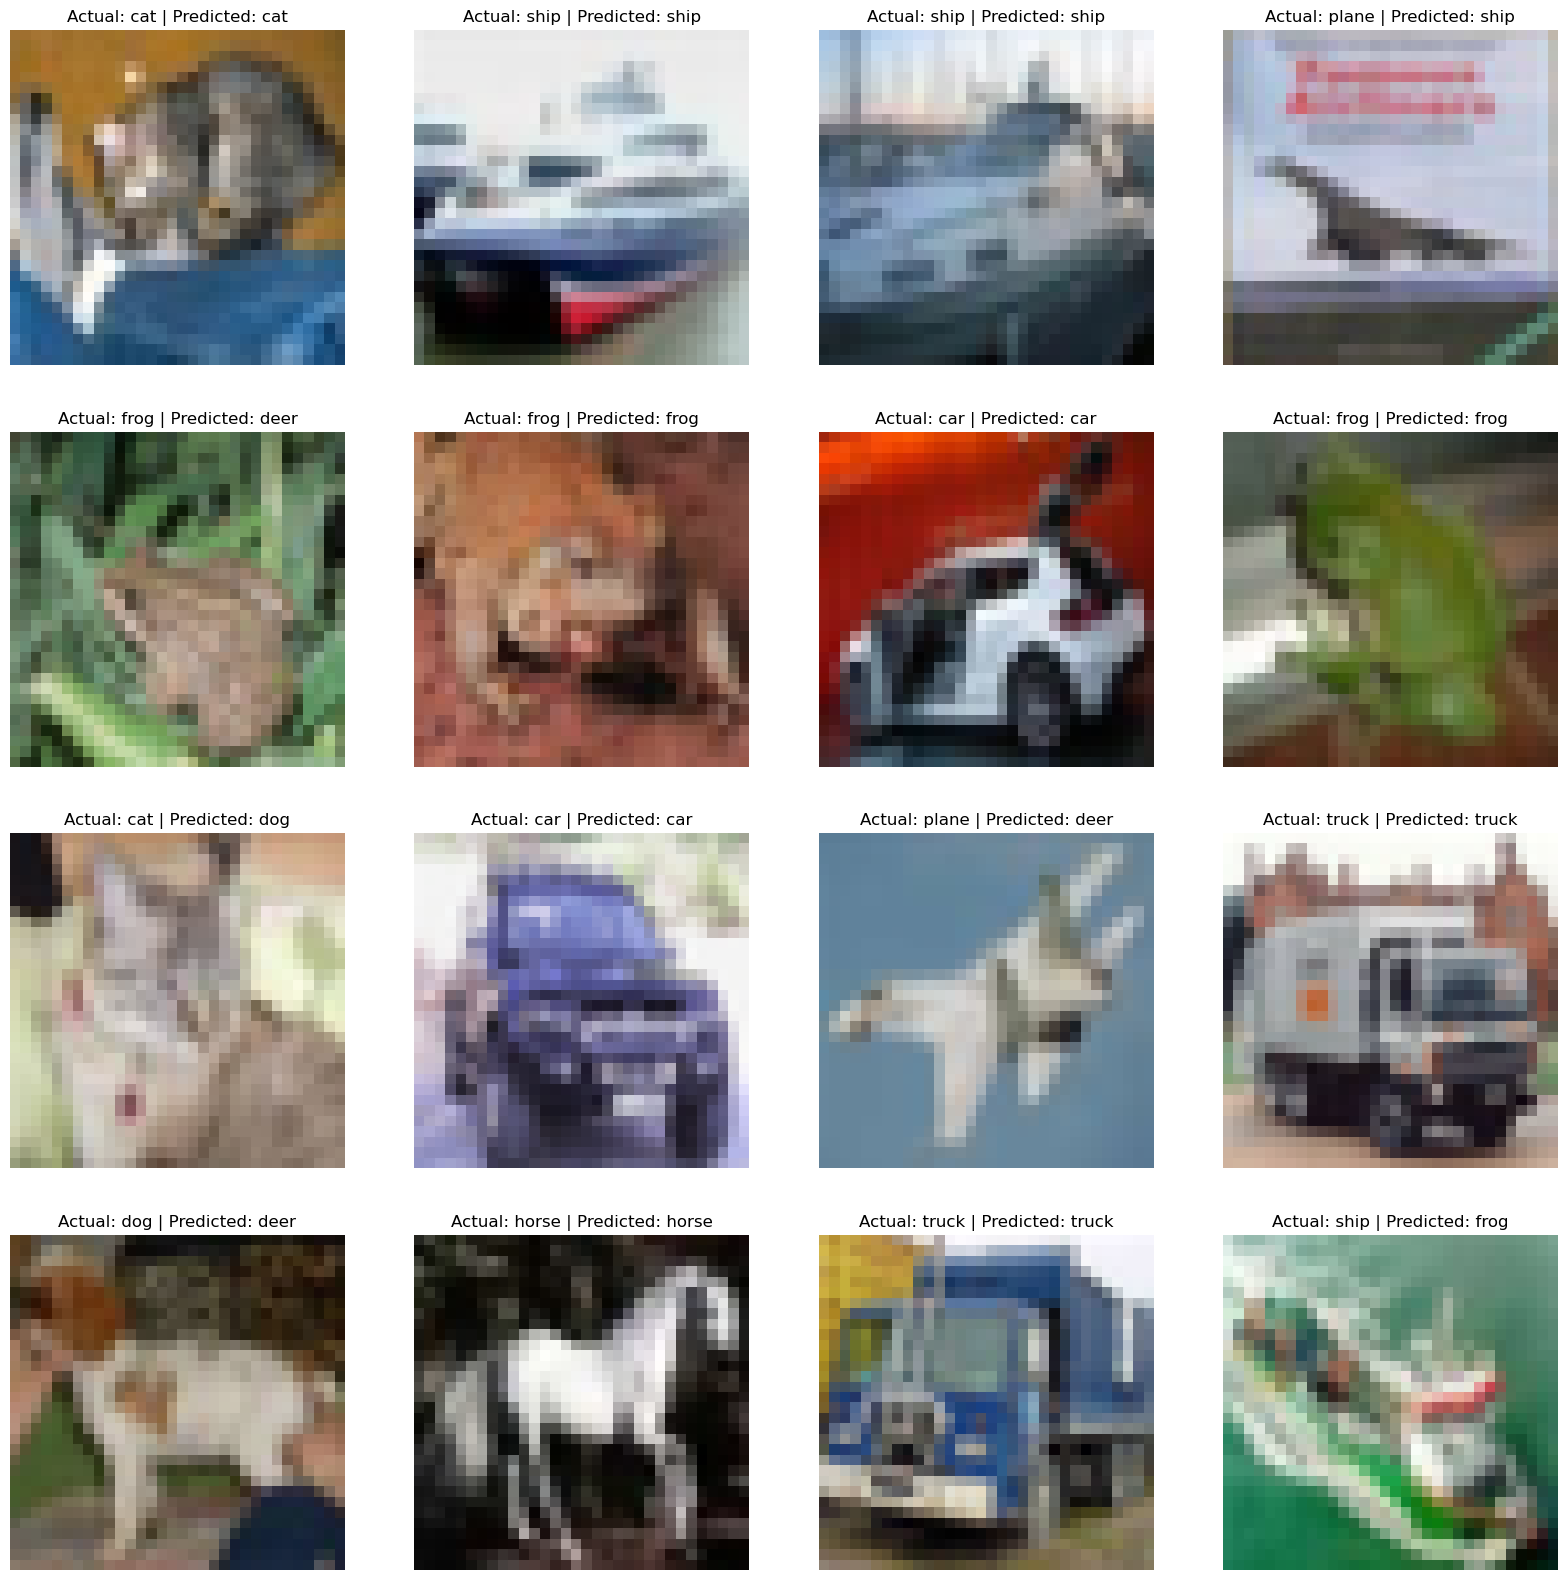

In [30]:
plt.figure(figsize=(20,20))
for i in range(16):
    # prediction
    with torch.no_grad():
        y_pred = model(X_test[i])
        y_hat = torch.argmax(y_pred)

    plt.subplot(4, 4, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we have multi-channel image
    img = np.transpose(img, (1,2,0))
    plt.imshow(img)
    plt.title("Label= " + str_labels[y_test[i].item()])
    plt.title("Actual: " + str_labels[y_test[i].item()] + " | Predicted: " + str_labels[y_hat.item()])
    plt.grid(False)
    plt.axis(False)
plt.show()